In [ ]:
#The code below comes from LSSTDESC/CCLX and uses that of:
#  Niko Sarcevic
#  nikolina.sarcevic@gmail.com
#  github.com/nikosarcevic
#and
#  Andrina Nicola
#  anicola[at]astro[dot]princeton[dot]edu
#  github.com/Andrina Nicola
#and
#  Elisa Chisari
#  n.e.chisari@uu.nl
#  #  github.com/elisachisari

!pip install -q condacolab

import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



Redshift Distribution: The redshift distribution is defined and plotted.


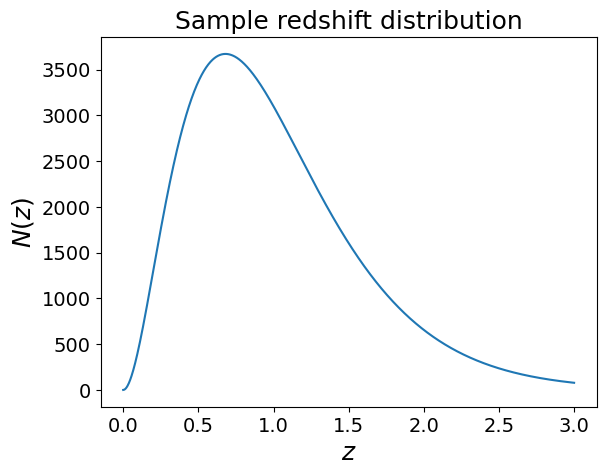

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from scipy import integrate
from scipy.special import erf

# Define the cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Define the redshift distribution
z = np.linspace(0., 3., 1024)
i_lim = 26.0  # Limiting i-band magnitude
z0 = 0.0417 * i_lim - 0.744
Ngal = 46.0 * 100.31 * (i_lim - 25.0)  # Normalization, galaxies/arcmin^2
pz = 1.0 / (2.0 * z0) * (z / z0)**2.0 * np.exp(-z / z0)  # Redshift distribution, p(z)
dNdz = Ngal * pz  # Number density distribution
b = 1.5 * np.ones(1024)  # Galaxy bias (constant with scale and z)

plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Sample redshift distribution', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()


Binning Class: The Binning class is defined to handle binning the redshift distribution into tomographic bins with equal number density.

Compute Equal Number Density Bins: The compute_equal_number_bounds method determines the bin edges that result in equal number densities.

Lens Bins: The lens_bins method computes the redshift distributions for each bin, normalizing them if specified.

Plotting: The redshift distributions for each bin are plotted to visualize the results.

Bin edges: [0.0, 0.5202868646340291, 0.7736946956027205, 1.0496654720590626, 1.4404486933924936, 3.0]


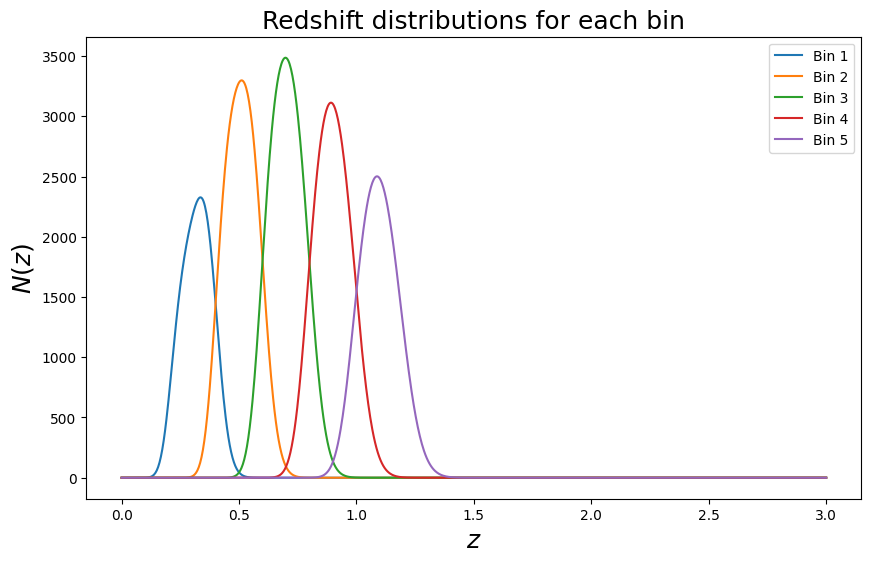

In [ ]:
class Binning:
    def __init__(self, redshift_range, redshift_distribution, forecast_year):
        supported_forecast_years = {"1", "10"}
        if forecast_year in supported_forecast_years:
            self.forecast_year = forecast_year
        else:
            raise ValueError(f"forecast_year must be one of {supported_forecast_years}.")

        self.redshift_range = redshift_range
        self.redshift_distribution = redshift_distribution

        with open("lsst_desc_parameters.yaml", "r") as f:
            self.lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

        self.lens_params = self.lsst_parameters["lens_sample"][self.forecast_year]
        self.source_params = self.lsst_parameters["source_sample"][self.forecast_year]

    def true_redshift_distribution(self, upper_edge, lower_edge, variance, bias):
        scatter = variance * (1 + self.redshift_range)
        lower_limit = (upper_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        upper_limit = (lower_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        true_redshift_distribution = 0.5 * np.array(self.redshift_distribution) * (erf(upper_limit) - erf(lower_limit))
        return true_redshift_distribution

    def compute_equal_number_bounds(self, redshift_range, redshift_distribution, n_bins):
        cumulative_distribution = integrate.cumulative_trapezoid(redshift_distribution, redshift_range, initial=0)
        total_galaxies = cumulative_distribution[-1]
        bin_edges = []
        for i in range(1, n_bins):
            fraction = i / n_bins * total_galaxies
            bin_edge = np.interp(fraction, cumulative_distribution, redshift_range)
            bin_edges.append(bin_edge)
        return [redshift_range[0]] + bin_edges + [redshift_range[-1]]

    def lens_bins(self, normalised=True, save_file=True, file_format='npy'):
        bins = np.arange(self.lens_params["bin_start"],
                         self.lens_params["bin_stop"] + self.lens_params["bin_spacing"],
                         self.lens_params["bin_spacing"])

        lens_z_bias_list = np.repeat(self.lens_params["z_bias"], self.lens_params["n_tomo_bins"])
        lens_z_variance_list = np.repeat(self.lens_params["sigma_z"], self.lens_params["n_tomo_bins"])

        lens_redshift_distribution_dict = {}
        for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
            z_bias = lens_z_bias_list[index]
            z_variance = lens_z_variance_list[index]
            lens_redshift_distribution_dict[index] = self.true_redshift_distribution(x1, x2, z_variance, z_bias)

        if normalised:
            norm_factor = []
            for i, key in enumerate(list(sorted(lens_redshift_distribution_dict.keys()))):

                norm_factor

        combined_data = {'redshift_range': self.redshift_range, 'bins': lens_redshift_distribution_dict}

        if save_file:
            self.save_to_file(combined_data, "lens", file_format)

        return lens_redshift_distribution_dict

    def get_bin_centers(self, decimal_places=2, save_file=True):
        bin_centers = {"sources": [], "lenses": []}
        lens_bins = self.lens_bins(normalised=True, save_file=False)
        for index in range(self.lens_params["n_tomo_bins"]):
            bin_center = self.find_bin_center(lens_bins[index], self.redshift_range, decimal_places)
            bin_centers["lenses"].append(bin_center)
        if save_file:
            np.save(f'./srd_bin_centers_y_{self.forecast_year}.npy', bin_centers)
        return bin_centers

    def find_bin_center(self, bin_distribution, redshift_range, decimal_places=2):
        max_index = np.argmax(bin_distribution)
        return round(redshift_range[max_index], decimal_places)

    def save_to_file(self, data, name, file_format="npy"):
        if file_format == "npy":
            np.save(f"./srd_{name}_bins_year_{self.forecast_year}.npy", data)
        elif file_format == "csv":
            dndz_df = pandas.DataFrame(data)
            dndz_df.to_csv(f"./srd_{name}_bins_year_{self.forecast_year}.csv", index=False)

# Instantiate and use the Binning class
forecast_year = "1"  # For year 1
binning = Binning(z, dNdz, forecast_year)

# Compute equal number density bins
n_bins = 5  # Number of bins for year 1
bin_edges = binning.compute_equal_number_bounds(z, dNdz, n_bins)
print("Bin edges:", bin_edges)

# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)
#print("Lens bins:", lens_bins)

# Plot the redshift distributions for each bin
plt.figure(figsize=(10, 6))
for i in range(n_bins):
    plt.plot(z, lens_bins[i], label=f'Bin {i+1}')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Redshift distributions for each bin', fontsize=18)
plt.legend()
plt.show()


Creating the NumberCountsTracer objects for each bin.

Plotting the Angular Power Spectra for each bin.

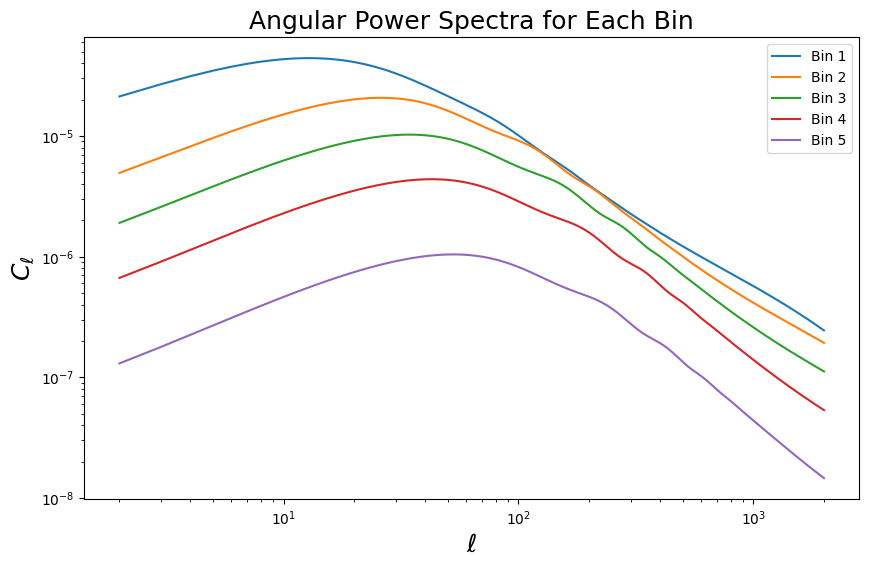

In [ ]:
# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)

# Create NumberCountsTracer objects for each bin
tracers = []
for i in range(n_bins):
    z_bin = z[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    dNdz_bin = dNdz[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    bias_bin = b[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, bias_bin))
    tracers.append(tracer)

# Specify angular multipoles
ell = np.arange(2, 2000)

# Calculate angular power spectra
cls = []
for tracer in tracers:
    cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

# Plot the angular power spectra
plt.figure(figsize=(10, 6))
for i, cl in enumerate(cls):
    plt.plot(ell, cl, label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Angular Power Spectra for Each Bin', fontsize=18)
plt.show()


Calculate the correlation functions for galaxy-galaxy clustering and plot them.

Define the angular scales.

Obtain the correlation predictions.

Plot the correlations.

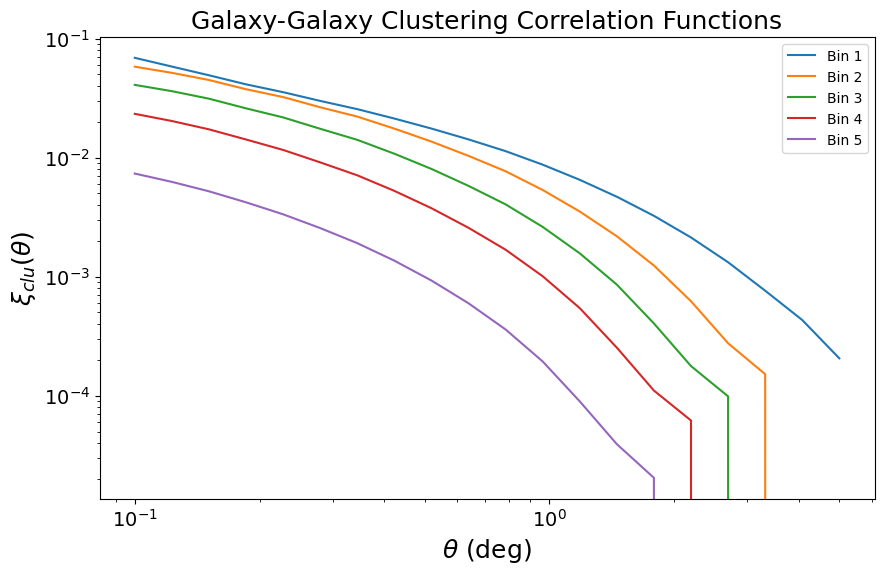

In [ ]:
# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin
correlations = []
for cl in cls:
    xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog')
    correlations.append(xi_clu)

# Plot the correlations for galaxy-galaxy clustering
plt.figure(figsize=(10, 6))
for i, xi_clu in enumerate(correlations):
    plt.plot(theta_deg, xi_clu, label=f'Bin {i+1}')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)', fontsize=18)
plt.ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
plt.title('Galaxy-Galaxy Clustering Correlation Functions', fontsize=18)
plt.show()


Auto-correlation: Gives insight into the clustering properties within individual redshift bins.

Cross-bin correlation: Provides information on how galaxies in different redshift bins correlate with each other, which can be influenced by projection effects and gravitational lensing. (see: Krywonos, J., Muir, J., Johnson, M.C., 2024. Improving Photometric Galaxy Clustering Constraints With Cross-Bin Correlations. arXiv:2404.08039v1 [astro-ph.CO]
See also , LSST DESC Requirements, appendix D1.2


Photo-z uncertainties: Affect both types of correlations by spreading galaxies across bins and impacting the precision of redshift binning.

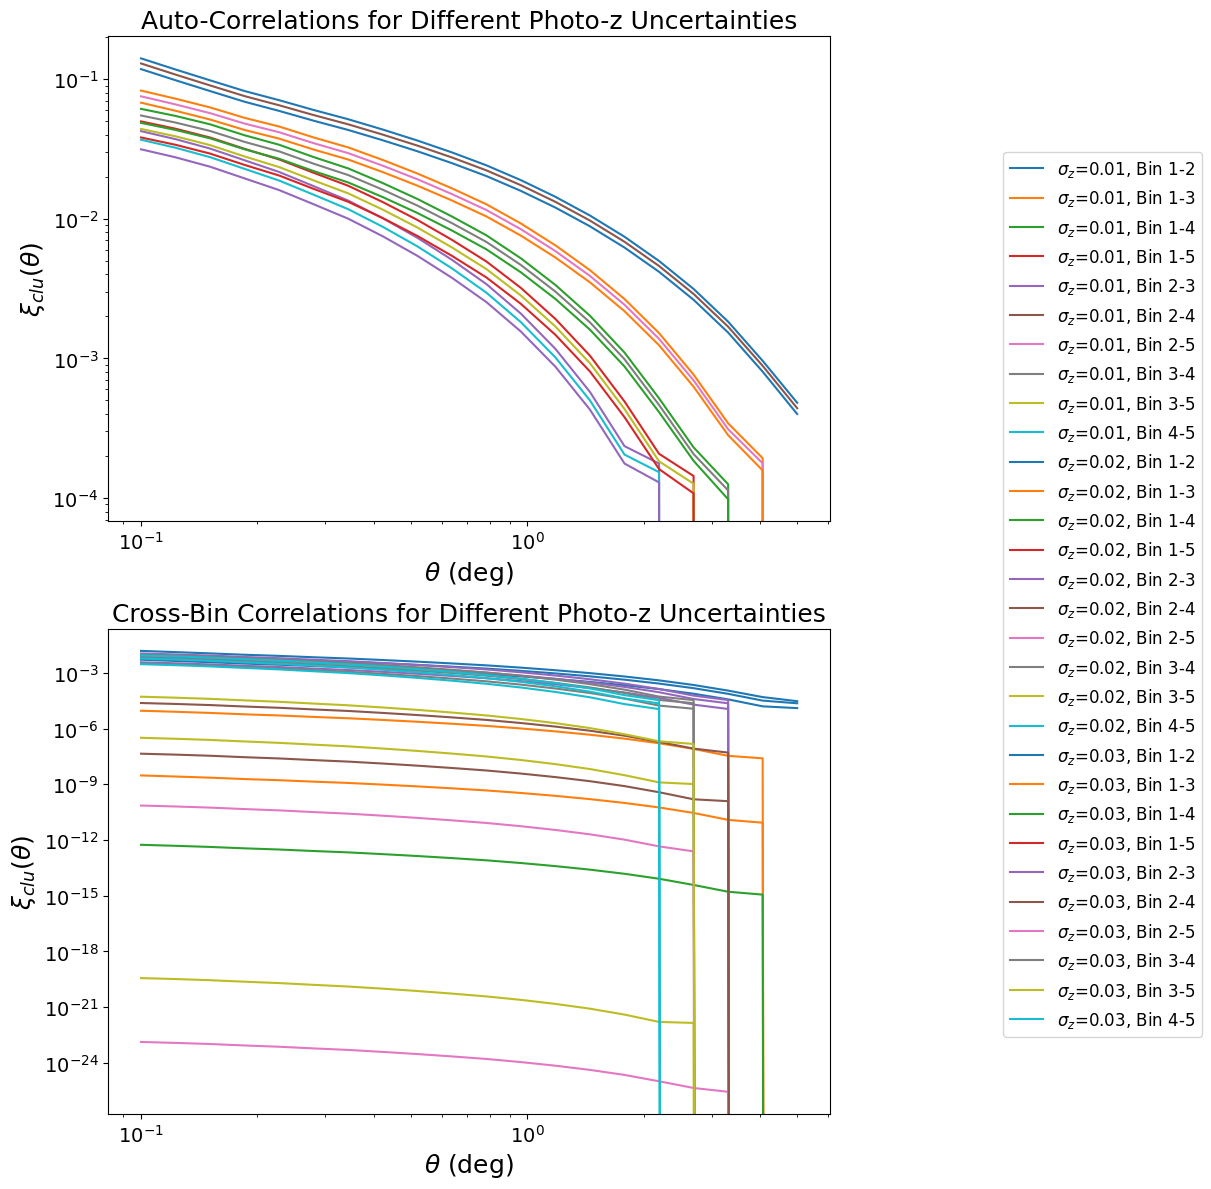

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a range of photo-z uncertainties to test
photoz_uncertainties = [0.01, 0.02, 0.03]

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Storage for correlation functions for different photo-z uncertainties
correlations_dict = {}

for sigma_z in photoz_uncertainties:
    # Recalculate the redshift distributions for each bin with the new photo-z uncertainty
    lens_redshift_distribution_dict = {}
    bins = np.arange(binning.lens_params["bin_start"],
                     binning.lens_params["bin_stop"] + binning.lens_params["bin_spacing"],
                     binning.lens_params["bin_spacing"])

    for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
        z_bias = binning.lens_params["z_bias"]
        lens_redshift_distribution_dict[index] = binning.true_redshift_distribution(x1, x2, sigma_z, z_bias)

    # Create the NumberCountsTracer objects for each bin
    tracers = []
    for i in range(n_bins):
        dNdz = lens_redshift_distribution_dict[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, dNdz), bias=(z, b), mag_bias=None)
        tracers.append(tracer)

    # Calculate the angular power spectra for each pair of bins (auto- and cross-bin correlations)
    cls_matrix = np.zeros((n_bins, n_bins, len(ell)))
    for i in range(n_bins):
        for j in range(n_bins):
            cls_matrix[i, j] = ccl.angular_cl(cosmo, tracers[i], tracers[j], ell)

    # Calculate the correlation function for each pair of bins
    correlations_matrix = np.zeros((n_bins, n_bins, len(theta_deg)))
    for i in range(n_bins):
        for j in range(n_bins):
            correlations_matrix[i, j] = ccl.correlation(cosmo, ell=ell, C_ell=cls_matrix[i, j], theta=theta_deg, type='NN', method='FFTLog')

    # Store the correlations for the current photo-z uncertainty
    correlations_dict[sigma_z] = correlations_matrix

# Plot the auto-correlations for different photo-z uncertainties
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
for sigma_z, correlations_matrix in correlations_dict.items():
    for i in range(n_bins):
        xi_clu = correlations_matrix[i, i]
        axs[0].plot(theta_deg, xi_clu, label=f'$\sigma_z$={sigma_z}, Bin {i+1}')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\theta$ (deg)', fontsize=18)
axs[0].set_ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
axs[0].set_title('Auto-Correlations for Different Photo-z Uncertainties', fontsize=18)
axs[0].tick_params(axis='both', which='major', labelsize=14)

# Plot the cross-bin correlations for different photo-z uncertainties
for sigma_z, correlations_matrix in correlations_dict.items():
    for i in range(n_bins):
        for j in range(i+1, n_bins):
            xi_clu = correlations_matrix[i, j]
            axs[1].plot(theta_deg, xi_clu, label=f'$\sigma_z$={sigma_z}, Bin {i+1}-{j+1}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\theta$ (deg)', fontsize=18)
axs[1].set_ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
axs[1].set_title('Cross-Bin Correlations for Different Photo-z Uncertainties', fontsize=18)
axs[1].tick_params(axis='both', which='major', labelsize=14)

# Create a tight column for the legends on the right
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


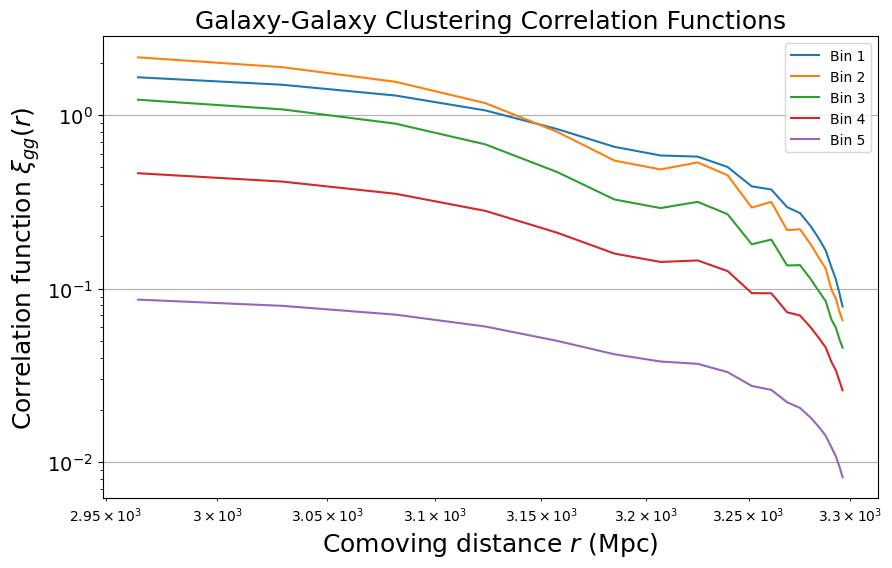

In [ ]:
# Define a cosmology
cosmo = ccl.Cosmology(
    Omega_c=0.25,  # Cold dark matter density parameter
    Omega_b=0.05,  # Baryonic matter density parameter
    h=0.7,         # Hubble constant in units of 100 km/s/Mpc
    sigma8=0.8,    # RMS amplitude of mass fluctuations in spheres of 8 Mpc/h
    n_s=0.96,      # Scalar spectral index
    transfer_function='bbks'  # Transfer function
)

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Convert angular scales to radians
theta_rad = np.deg2rad(theta_deg)

# Calculate redshifts corresponding to the angular scales
# Use ccl.background.angular_diameter_distance to get comoving angular diameter distance
# and then convert it to redshift
chi = ccl.background.angular_diameter_distance(cosmo, 1./(1. + theta_rad))
z = 1 - 1./chi

# Ensure that scale factors are less than or equal to 1
a = 1. / (1. + z)
a[a > 1] = 1.  # Set scale factors greater than 1 to 1

# Calculate comoving radial distances corresponding to the redshifts
r = ccl.comoving_radial_distance(cosmo, a)

# Calculate the correlation function ξ_gg(r) for each bin
correlations = []
for cl in cls:
    xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_rad, type='NN', method='FFTLog')
    correlations.append(xi_clu)

# Plot ξ_gg(r) vs. r
plt.figure(figsize=(10, 6))
for i, xi_clu in enumerate(correlations):
    plt.plot(r, xi_clu, label=f'Bin {i+1}')

plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right')
plt.xlabel(r'Comoving distance $r$ (Mpc)', fontsize=18)
plt.ylabel(r'Correlation function $\xi_{gg}(r)$', fontsize=18)
plt.title('Galaxy-Galaxy Clustering Correlation Functions', fontsize=18)
plt.grid(True)
plt.show()